2018 Aug 10<br>
Now that I've figured out I've been distorting the transit by not masking it when I filter the data, I will check again how Faigler's fit (calculated by evilmc) compares to the data.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from pymc import geweke
from pymc.Matplot import geweke_plot
from corner import quantile

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import *

from scipy.signal import lombscargle

from lmfit import minimize, Parameters, Minimizer
from emcee.autocorr import integrated_time, function
import corner

from variable_eclipses_utils import *
from BEER_curve import BEER_curve

import dill

K76 = Kepler76_params()

exp_time = 30./60./24.

# Official Boise State colors - https://brandstandards.boisestate.edu/colors/
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

aspect_ratio = 16./9

In [2]:
# From Faigler+ (2013 - http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta)
semi = 1./0.221 #± 0.003
imp = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
period = 1.54492875
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s)

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*semi
Ms = 1.2*u.solMass # ± 0.2
mass_ratio = Mp.to('kg').value/Ms.to('kg').value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
logg = 4.388
m_over_H = -0.033
Omegas = vsini.to('m/s').value/Rs.to('m').value*period*86400.

Ts = 6300. # ± 200

T0 = 0.68508434

Faigler_T0 = (737.49 + 2455000. - 2454833.) % period # ±0.19

coeffs = [0.313, 0.304]
# From https://github.com/nespinoza/limb-darkening
non_lin_coeffs = [0.37915857, 0.62585528, -0.34986866, 0.05968292]

saved_ep = evparams(per=period, a=semi, T0=T0, p=Rp_over_Rs,
                    limb_dark="quadratic", b=imp, F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, 
                    q=mass_ratio, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)

print(transit_duration(saved_ep)*24.*60.)

87.62617978877473


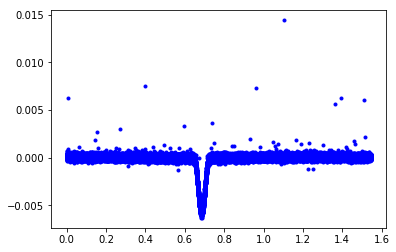

In [5]:
time, flux, filtered_time, filtered_flux = retreive_data(period, params=saved_ep)
folded_time = filtered_time % period
plt.plot(folded_time, filtered_flux, 'b.')

# em = evmodel(folded_time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
# %time sig = em.all_signals()

# plt.plot(folded_time, sig, 'r.')
# plt.ylim([-0.001, 0.001])
# plt.axhline(0.)

(0.625, 0.75)

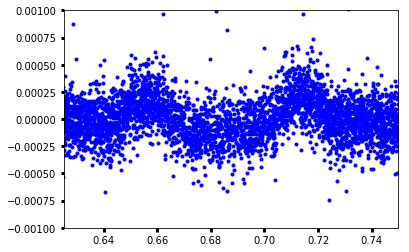

In [11]:
# Not a great fit

plt.plot(folded_time, filtered_flux - sig, 'b.')
plt.ylim([-0.001, 0.001])
plt.xlim([0.625, 0.75])

In [11]:
def fit_signal(time, T0, a, p, i, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0]
(array([ 0.6849869 ,  5.24492264,  0.08556379, 80.08421521]), array([2.21827453e-05, 5.03671095e-02, 4.49875621e-04, 1.25991744e-01]))


(-0.002, 0.002)

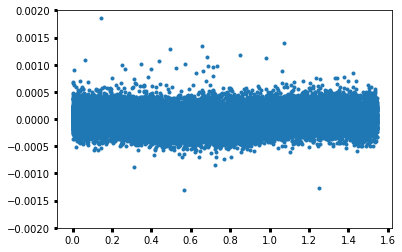

In [57]:
# Let's try with some real data
time = folded_time
flux = filtered_flux

initial_guess = [T0, semi, Rp_over_Rs, inc]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70.], [0.8, 6., 0.2, 95.]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - fit_signal(time, *popt), marker='.', ls='')
plt.ylim([-0.002, 0.002])
# plt.xlim([0.64, 0.725])

(0.64, 0.725)

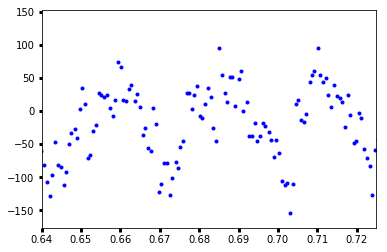

In [49]:
# Not fantastic, but decent - Let's try fitting the limb-darkening parameters?

resid = flux - fit_signal(time, *popt)
binned_time, binned_resid, binned_err = bindata(time, resid, binsize=1./60./24.)

plt.plot(binned_time, binned_resid*1e6, 'b.')
plt.xlim([0.64, 0.725])

In [52]:
def fit_signal(time, T0, a, p, i, u1, u2, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = u1
    model["quadLimb"] = u2
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0, 0.313, 0.304]
(array([ 0.68498892,  5.24329189,  0.08787176, 80.16558656,  0.29950668,
        0.53278529]), array([2.64051822e-05, 1.14176725e+00, 3.22433239e-02, 2.62705460e+00,
       6.09252502e+00, 6.46569178e+00]))


(-0.001, 0.001)

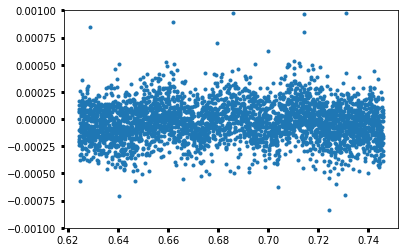

In [53]:
# Focus on just the transit
dur = transit_duration(saved_ep)
ind = np.abs(folded_time - T0) <= dur

time = folded_time[ind]
flux = filtered_flux[ind]

initial_guess = [T0, semi, Rp_over_Rs, inc, coeffs[0], coeffs[1]]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70., 0., 0.], [0.8, 6., 0.2, 95., 1., 1.]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - fit_signal(time, *popt), marker='.', ls='')
plt.ylim([-0.001, 0.001])
# plt.xlim([0.64, 0.725])

In [6]:
resid = flux - fit_signal(time, *popt)
binned_time, binned_resid, binned_err = bindata(time, resid, binsize=1./60./24.)

plt.plot(binned_time, binned_resid*1e6, 'b.')

NameError: name 'fit_signal' is not defined

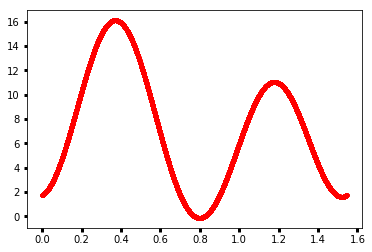

In [66]:
# OK, let's try to subtract off all the other variations except the transit and then fit what's left

time = folded_time
flux = filtered_flux

em = evmodel(time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
sig = em.evilmc_signal()

#plt.plot(time, flux, 'b.')
plt.plot(folded_time, sig*1e6, 'r.')

In [7]:
# 2018 Aug 11 - Introducing arbitrary baseline shift among fit parameters
def fit_signal(time, T0, a, p, i, baseline, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1. + baseline
        
    return ret

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0, 0.0]
(array([6.84983265e-01, 5.49556551e+00, 8.39177083e-02, 8.06436123e+01,
       5.16262658e-05]), array([2.59012227e-05, 7.12037511e-02, 4.66408086e-04, 1.60145123e-01,
       4.86671100e-06]))
(2.736434636785233e-11, 195.86275187639552)


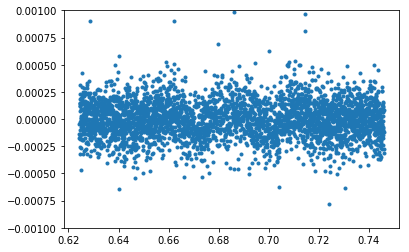

In [20]:
# Focus on just the transit
dur = transit_duration(saved_ep)
ind = np.abs(folded_time - T0) <= dur

time = folded_time[ind]
flux = filtered_flux[ind]

initial_guess = [T0, semi, Rp_over_Rs, inc, 0.]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70., -100e-6], [0.8, 6., 0.2, 95., 100e-6]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

sig = fit_signal(time, *popt)
resid = flux - sig

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, resid, marker='.', ls='')
plt.ylim([-0.001, 0.001])
# plt.xlim([0.64, 0.725])

print(np.mean(resid), np.std(resid)*1e6)

2018 Aug 13<br>
Since it seems that my earlier issues with fitting transits were not obviously due to the binning, I'm going to try to bin things again to save time.

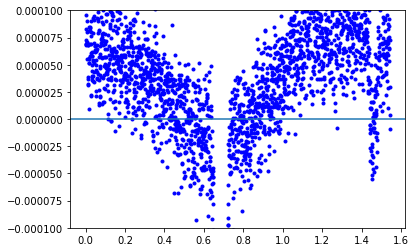

In [7]:
binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=1./60./24.)
plt.plot(binned_time, binned_flux, 'b.')

# em = evmodel(binned_time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
# %time sig = em.all_signals()

#plt.plot(binned_time, sig, 'r.')
plt.ylim([-0.0001, 0.0001])
plt.axhline(0.)

(array([ 3.23700115e-03,  2.51209273e-05,  5.01989032e-05, -2.26189644e-02]), array([2.63020992e-04, 1.51463550e-06, 1.03405532e-06, 2.74279018e-03]))
(2.852521389942272e-05, -1.7344463635581266e-07)


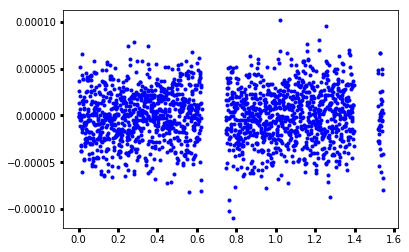

In [35]:
# 2018 Aug 14 - Fitting out the EVs first

def fit_signal(time, q, F0, Aplanet, phase_shift):
    ep = saved_ep
    ep.q = q
    ep.F0 = F0
    ep.Aplanet = Aplanet
    ep.phase_shift = phase_shift
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

dur = transit_duration(saved_ep)
ind =   (np.abs(binned_time - saved_ep.T0) > dur) &\
        (np.abs(binned_time - (saved_ep.T0 + 0.5*period)) > dur)

time = binned_time[ind]
flux = binned_flux[ind]
err = binned_err[ind]

initial_guess = [1e-2, 25e-6, 25e-6, 10.*np.pi/180.]
popt, pcov = curve_fit(fit_signal, time, flux, sigma=err, p0=initial_guess, bounds=([0., -100e-6, -100e-6, -1.], [0.1, 100e-6, 100e-6, 1.]))
print(popt, np.sqrt(pcov.diagonal()))

ep = evparams(per=period, a=semi, T0=T0, p=Rp_over_Rs,
                    limb_dark="quadratic", b=imp, F0=popt[1], Aplanet=popt[2], phase_shift=popt[3], beta=0.07, 
                    q=popt[0], Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
sig = fit_signal(time, *popt)

ev_ep = ep

resid = flux - fit_signal(time, *popt)
plt.plot(time, resid, 'b.')

print(np.std(resid), np.mean(resid))

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0, 0.0]
(array([6.84977660e-01, 5.45348925e+00, 8.39605243e-02, 8.05624834e+01,
       9.54736891e-08]), array([2.19003138e-05, 5.00704145e-02, 3.36802436e-04, 1.15049441e-01,
       6.48177315e-07]))
(3.090117780740199e-05, 2.236008863106806e-05, -2.28189996426806e-07)


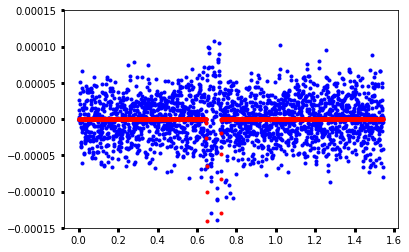

In [46]:
# 2018 Aug 14 - Now fitting just the transit portion
def fit_signal(time, T0, a, p, i, baseline, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1. + baseline
        
    return ret

time = binned_time
flux = binned_flux
err = binned_err

ev_ep.p = 0.
em = evmodel(time, ev_ep, supersample_factor=5, exp_time=30./60./24.)
evs = em.all_signals()
flux = flux - evs

# plt.plot(time, flux, 'b.')
# plt.ylim([-0.0001, 0.0001])

initial_guess = [T0, semi, Rp_over_Rs, inc, 0.]

popt, pcov = curve_fit(fit_signal, time, flux, sigma=err,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70., -100e-6], [0.8, 6., 0.2, 95., 100e-6]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, 'b.')
# plt.plot(time, fit_signal(time, *popt), 'r.')
resid = flux - fit_signal(time, *popt)
plt.plot(time, resid, 'b.')
plt.plot(time, fit_signal(time, *popt), 'r.')
plt.ylim([-0.00015, 0.00015])
print(np.std(resid), np.median(err), np.mean(resid))

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0, 0.0]
(array([6.84995413e-01, 4.57086574e+00, 8.29454694e-02, 7.80743027e+01,
       1.81692632e-05]), array([1.98631329e-05, 5.15587029e-02, 1.54063399e-03, 1.89006489e-01,
       6.45294009e-07]))
(3.0168151181716e-05, 2.23054809172717e-05, -2.590724297469649e-07)


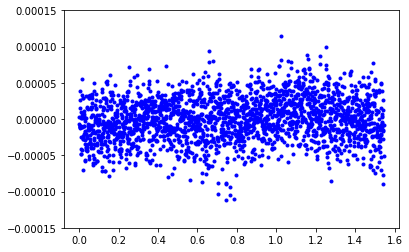

In [14]:
# 2018 Aug 14 - The transit fit above is decent, not great. Maybe I need to use a non-linear LD law?
#
# !! supersample_factor has to be larger than 5 !!

def fit_signal(time, T0, a, p, i, baseline, supersample_factor=10, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="nl")

    # Set parameters
    model["per"] = period
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
#     model["a1"] = non_lin_coeffs[0]
#     model["a2"] = non_lin_coeffs[1]
#     model["a3"] = non_lin_coeffs[2]
#     model["a4"] = non_lin_coeffs[3]
    model["a1"] = 0.
    model["a2"] = 0.
    model["a3"] = 0.
    model["a4"] = 0.

    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1. + baseline
        
    return ret

# dur = transit_duration(saved_ep)
# ind = np.abs(binned_time - T0) < 2.*dur

ind = binned_time == binned_time

time = binned_time[ind]
flux = binned_flux[ind]
err = binned_err[ind]

saved_ep.p = 0.
em = evmodel(time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
evs = em.all_signals()
flux = flux - evs

# plt.plot(time, flux, 'b.')
# plt.ylim([-0.0001, 0.0001])

initial_guess = [T0, semi, Rp_over_Rs, inc, 0.]

popt, pcov = curve_fit(fit_signal, time, flux, sigma=err,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70., -100e-6], [0.8, 6., 0.2, 95., 100e-6]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, 'b.')
# plt.plot(time, fit_signal(time, *popt), 'r.')
resid = flux - fit_signal(time, *popt)
plt.plot(time, resid, 'b.')
plt.ylim([-0.00015, 0.00015])
print(np.std(resid), np.median(err), np.mean(resid))

2018 Dec 4 <br>
Exploring any problems with crowding<br>

From Faigler et al. (2013) - "The fitted amplitudes, after correction for a third light using the KIC estimate, are listed in Table 6."

Trying to figure out where the crowding metric is given in the data files, I came across the following from the KEPLER DATA PROCESSING HANDBOOK (https://archive.stsci.edu/kepler/manuals/KSCI-19081-002-KDPH.pdf):
"PDC also identifies and removes isolated outliers and corrects the flux time series for crowding effects and for the fact that not all the light from a star can be captured by a finite aperture..."

From Stumpe+ (2012) PASP 124, 985, section 2.3.11, it seems pretty clear that the contribution from nearby stars is removed from the PDCSAP_FLUX time-series.

In [5]:
# Calculate BEER_curve
def calc_BEER_curve(time, params, exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    BC = BEER_curve(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    return BC.all_signals()

def residuals(params, time, data, eps_data=1., model_to_use=calc_BEER_curve, 
              exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    model = model_to_use(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    
    return (data - model)/eps_data

In [35]:
# 2018 Dec 5 - Dilution turned off!
unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, 
                                                                               num_periods=4, 
                                                                               KIC=K76.KIC, params=K76.saved_ep, 
                                                                               drop_outliers=True)#, dilution=True)
folded_time = filtered_time % K76.saved_ep.per

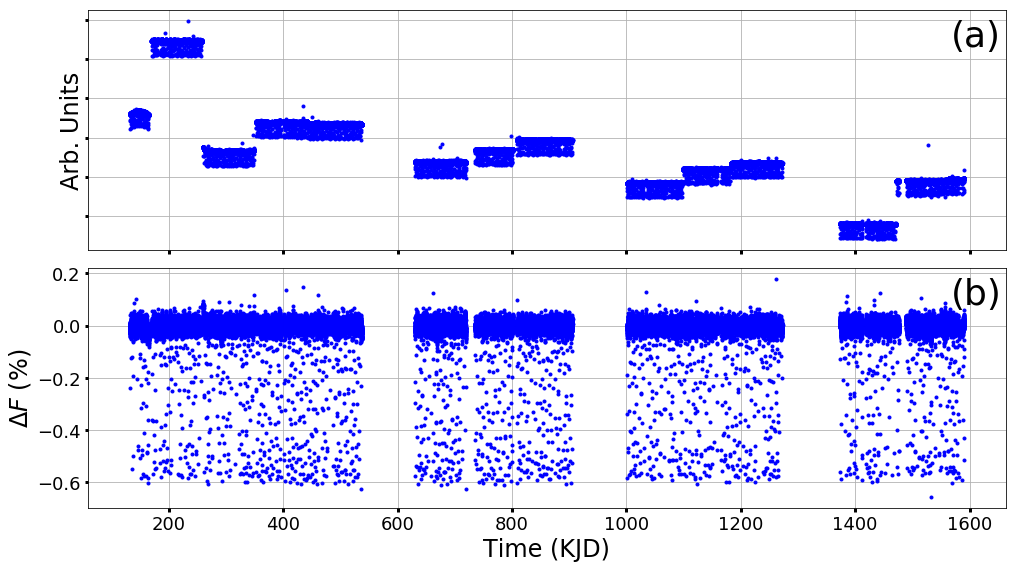

In [36]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, 'b.')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Abeam          1.127e-05   -0.001    0.001     None     True     None     None
Aellip         1.276e-05   -0.001    0.001     None     True     None     None
Aplanet        4.991e-05   -0.001    0.001     None     True     None     None
T0               0.6851     -inf      inf     None    False     None     None
a                 4.525     -inf      inf     None    False     None     None
b                 0.944     -inf      inf     None    False     None     None
baseline       1.838e-06   -0.001    0.001     None     True     None     None
eclipse_depth   8.9e-05   -0.001    0.001     None     True     None     None
per               1.545     -inf      inf     None    False     None     None
phase_shift    -0.0003541   -0.001    0.001     None     True     None     None
None
3.2104592008658296e-08


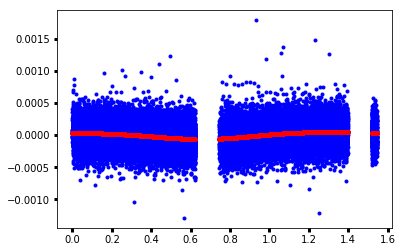

In [37]:
# 2018 Nov 16 - Trying to fit out the BEER signals BEFORE fitting the transit to see if that will make my results
#   agree with Faigler et al.'s.
BEER_only_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Abeam', value=13e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('phase_shift', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('eclipse_depth', value=89e-6, min=-1000e-6, max=1000e-6)

# Grab the out-of-transit portion
ind = ~( transit_indices(folded_time, 2.*K76.dur, K76.T0) |\
         transit_indices(folded_time, 2.*K76.dur, K76.T0 + 0.5*K76.per.to('day').value) )

time = folded_time[ind]
data = filtered_flux[ind]
err = np.ones_like(data) # Don't worry about scatter.

plt.plot(time, data, 'b.')

BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)

plt.plot(time, BEER_only_model, 'r.')
print(BEER_only_out.params.pretty_print())
print(BEER_only_out.redchi)

In [38]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.607e-05     True     None     None
a            5.115        2       10  0.05502     True     None     None
b           0.9072       -1        1 0.002863     True     None     None
baseline  -1.021e-05   -0.001    0.001 5.013e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08463        0      0.2 0.0005168     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.277345594695135


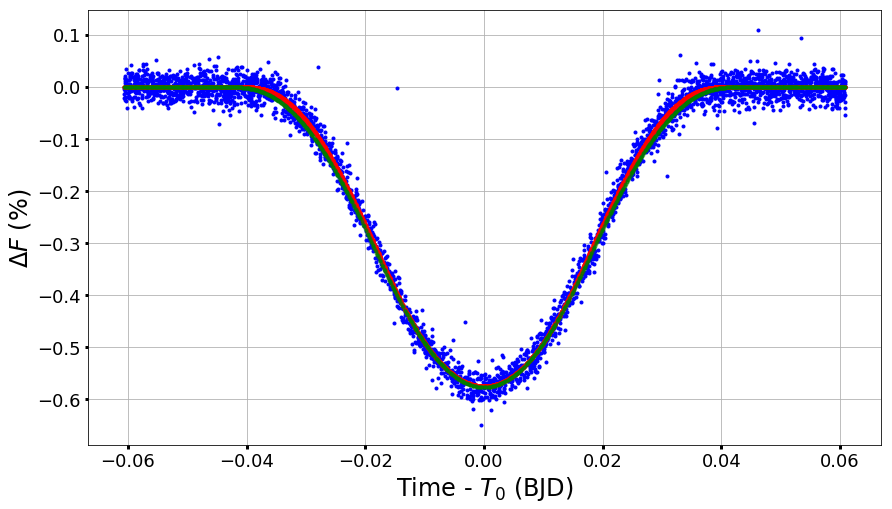

In [47]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')

Faigler_params = K76.saved_params.copy()
Faigler_params['baseline'] = out.params['baseline']
Faigler_params['T0'] = out.params['T0']
ax.plot(time - out.params['T0'], fit_transit(time, Faigler_params)*100, 'g.', alpha=0.25)

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

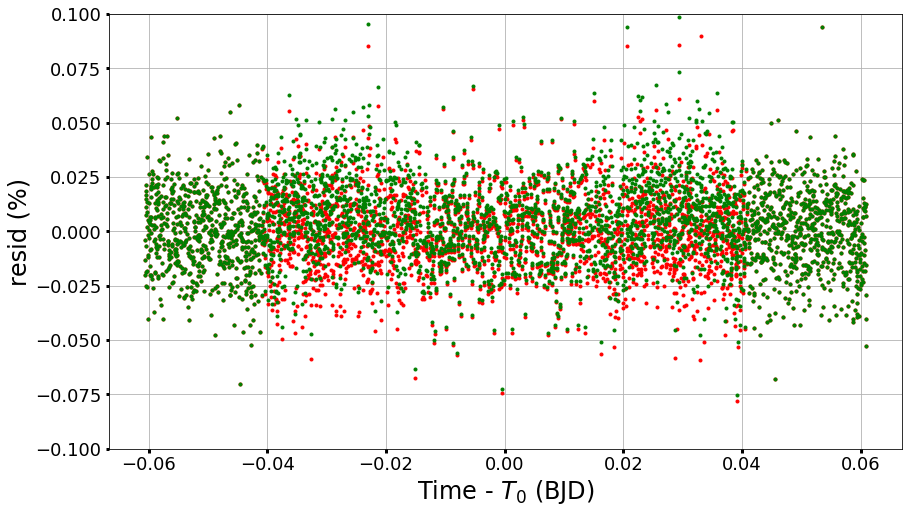

In [50]:
# residuals
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], (data - fit_transit(time, out.params))*100, 'r.')

Faigler_params = K76.saved_params.copy()
Faigler_params['baseline'] = out.params['baseline']
Faigler_params['T0'] = out.params['T0']
ax.plot(time - out.params['T0'], (data - fit_transit(time, Faigler_params))*100, 'g.')

ax.set_ylim([-0.1, 0.1])

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("resid (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

In [43]:
Faigler_mod = fit_transit(time, Faigler_params)
ind = Faigler_mod < out.params['baseline']
Faigler_model_duration = np.max(time[ind]) - np.min(time[ind])

# The duration as inferred from the transit lightcurve using Faigler's fit parameters should be about
#   one observing cadence (30 min) longer than the exact duration because of Kepler's large exposure time.
print((Faigler_model_duration)*60.*24, (transit_duration(K76.saved_ep))*60.*24, 
      (Faigler_model_duration - transit_duration(K76.saved_ep))*60.*24)

# And what duration does my best-fit transit suggest?
my_mod = fit_transit(time, out.params)
ind = my_mod < out.params['baseline']
my_model_duration = np.max(time[ind]) - np.min(time[ind])

print(my_model_duration*60.*24, transit_duration(out.params)*60.*24, 
      (my_model_duration - transit_duration(out.params))*60.*24)

(119.52625148825213, 87.62617978877472, 31.900071699477405)
(113.73518986872348, 82.49239272221398, 31.2427971465095)


Even using the dilution factor (which I'm not sure I should be doing), I still can't reproduce Faigler's results. What if I turned off supersampling?

In [15]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit, 'exp_time': 0., 'supersample_factor': 1})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.831e-05     True     None     None
a            3.946        2       10  0.04113     True     None     None
b                1       -1        1 0.003516     True     None     None
baseline  -4.994e-05   -0.001    0.001 5.36e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p           0.1267        0      0.2 0.008727     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
4.52488687783
1.605839354047302


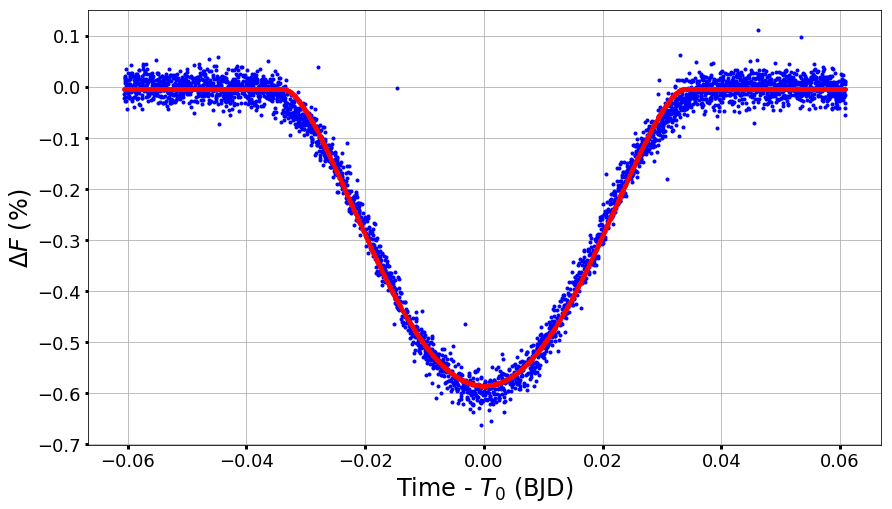

In [14]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params, exp_time=0, supersample_factor=1)*100, 'r.')

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

What if we didn't supersample AND didn't subtract the BEER curve fit?

In [16]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit, 'exp_time': 0., 'supersample_factor': 1})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.831e-05     True     None     None
a            3.946        2       10  0.03973     True     None     None
b                1       -1        1  0.01198     True     None     None
baseline  -0.0001109   -0.001    0.001 5.358e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p           0.1268        0      0.2 0.008425     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.6069414571467173


What if we supersampled but didn't subtract the BEER curve fit?

In [17]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.641e-05     True     None     None
a            5.147        2       10  0.05563     True     None     None
b           0.9059       -1        1 0.002926     True     None     None
baseline  -7.121e-05   -0.001    0.001 5.266e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08608        0      0.2 0.0005331     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.3110841955606287


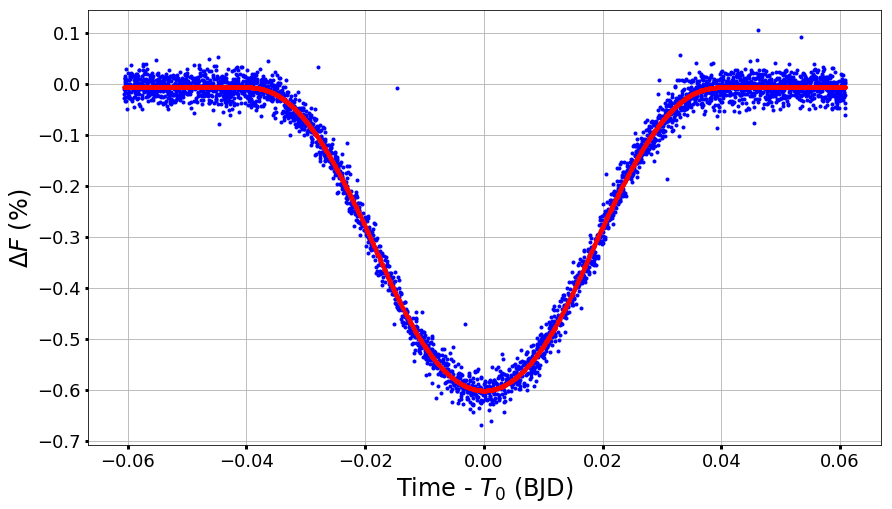

In [19]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

OK, do I mask out the transit when I detrend? From variable_eclipse_utils.py:
~~~~
# Indicate all points in transit
ind = None
if(params is not None):
    folded_time = cur_time % period

    dur = transit_duration(params, which_duration='full')

    # This expression below should technically be
    # ind = np.abs(folded_time - params.T0) < 0.5*dur, but
    # I'm taking a little window to either side of the transit
    # to make sure I'm masking everything.
    if(type(params) is dict):
        T0 = params['T0']
    else:
        T0 = params.T0
    ind = np.abs(folded_time - T0) < dur

filt = median_boxcar_filter(cur_time, cur_flux,
    window_length, mask_ind=ind)
~~~~

And then from transit_utils.median_boxcar_filter:
~~~~
# If mask_ind provided, interpolate across the masked points
if(mask_ind is not None):
    not_mask_ind = ~mask_ind
    filter_array[mask_ind] = np.interp(time[mask_ind],
            time[not_mask_ind], filter_array[not_mask_ind])
~~~~

So it really looks like I'm masking the transit. Just as a final check, let's NOT mask the transit when detrending.

In [51]:
unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, 
                                                                               num_periods=4, 
                                                                               KIC=K76.KIC, drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

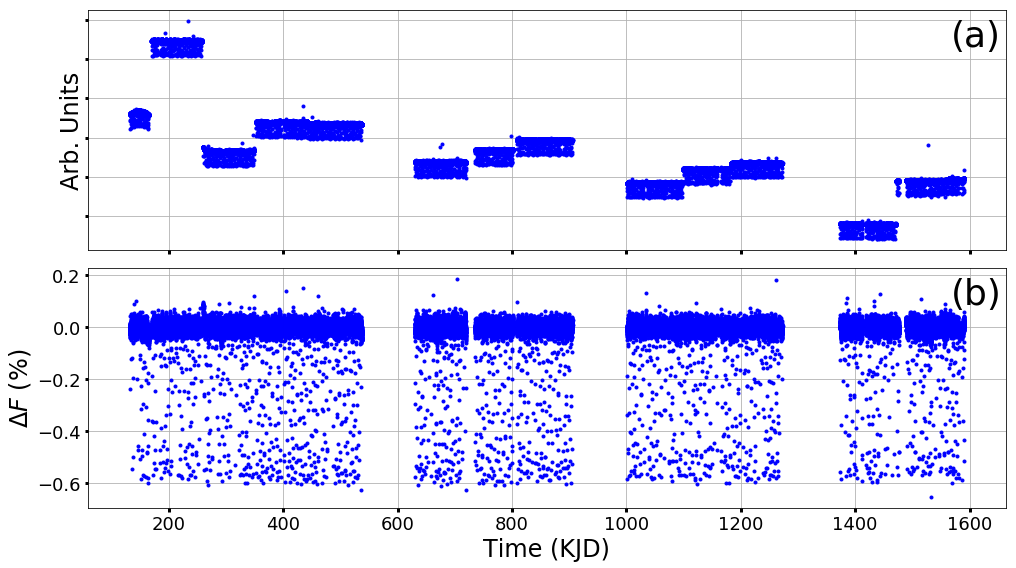

In [52]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, 'b.')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

In [53]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.604e-05     True     None     None
a            5.108        2       10   0.0543     True     None     None
b           0.9076       -1        1 0.002828     True     None     None
baseline  -8.882e-07   -0.001    0.001 5.003e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08469        0      0.2 0.000516     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.2796164574080726


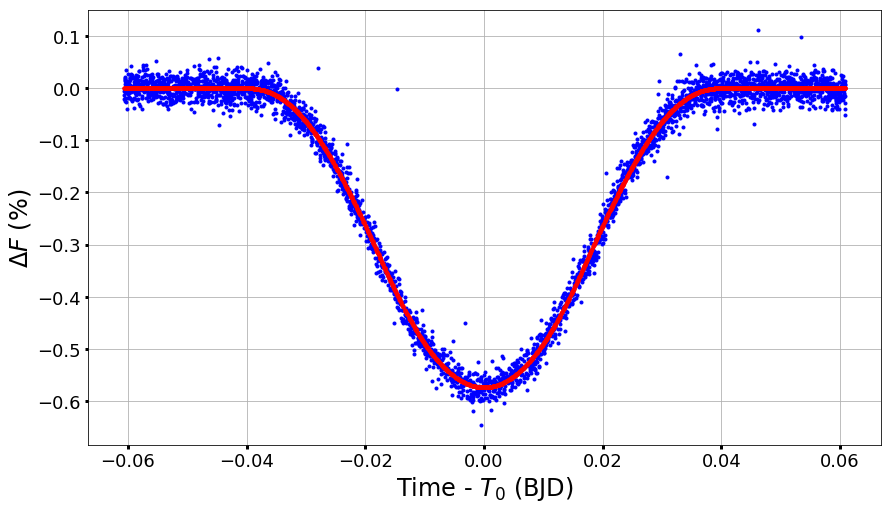

In [54]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

Just as a final check, I'll detrend the data, using the wrong mid-transit time but all the other correct transit parameters.

In [56]:
false_transit_params = K76.saved_params.copy()
print(false_transit_params['T0'])
false_transit_params['T0'] = K76.saved_params['T0'] + 0.5*K76.saved_params['per']

0.68508434
1.457548715


In [57]:
unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, 
                                                                               num_periods=4, 
                                                                               KIC=K76.KIC, 
                                                                               params=false_transit_params, 
                                                                               drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

In [59]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(K76.Rp_over_Rs)
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.603e-05     True     None     None
a            5.115        2       10   0.0549     True     None     None
b           0.9072       -1        1 0.002854     True     None     None
baseline  -3.528e-06   -0.001    0.001 5.009e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08463        0      0.2 0.0005152     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
0.0968325791855
1.2771119503083506


Exactly the same as above. Keep in mind the median boxcar filter window size is four orbital periods, so it's not surprising that masking out the transit (which is two or three points per orbit) makes no difference.

---

Just as a quick check, how different is the mass ratio inferred from the EV signal?<br>

My best-fit EV amplitude is about 13.22 ppm (see Analysis_of_Kepler76b.ipynb), while Faigler's is 21.1 $\pm$ 1.7 ppm. With $a/R_\star = 5.1$ (Faigler's is $4.52 \pm 0.06$), and my $b = 0.9 \pm 0.003$ (Faigler's is $0.944 \pm 0.011$). My $b$-value translates into $i = \cos^{-1} \left( b\ R_\star/a \right) = 79.83^\circ$ (Faigler's $i = 78.0^\circ \pm 0.2^\circ$).<br>

From Jackson et al. (2012 - http://adsabs.harvard.edu/abs/2012ApJ...751..112J), we have <br>
$A_{\rm ellip} = \alpha_{\rm ellip}\ q \sin^2 i\ \left( R_\star / a \right)^3$.<br>

$\alpha_{\rm ellip} = 0.15 (15 + u)(1 + g)/(3 - u) = 1.02$, with $u = 0.55177124$ (see Kepler76_output_file.dat) and $g \approx 0.07$ (from Jackson+ 2012). I'll just call $\alpha_{\rm ellip} = 1$ since I don't know what Faigler used.<br>

So the new planetary mass $M_{\rm p}^\prime = M_{\rm p} \dfrac{A_{\rm ellip}^\prime}{A_{\rm ellip}}\ \dfrac{\sin^2 i}{\sin^2 i^\prime}\ \left( a^\prime/R_\star^\prime \right)^3\ \left( a/R_\star \right)^{-3} = 1.9\ {\rm M_{Jup}}$. This result is only 0.5-$\sigma$ from the solution given by Faigler for the EV mass.

---

However, my $R_{\rm p}/R_\star = 0.0860 \pm 0.0005$, compared to Faigler's $R_{\rm p}/R_\star = 0.0968 \pm 0.0003$ (see notes from 2018 Nov 13). That's a difference of 18.5-$\sigma$!<br>

So my $R_{\rm p} = 1.11\ {\rm R_{Jup}}$, instead of $1.25 \pm 0.08\ {\rm R_{Jup}}$. In Jupiter radii, my radius is only about 1.75-$\sigma$ off.